<a href="https://colab.research.google.com/github/Ahmad162539/ML-class-excercise-codes/blob/main/AlphaFold_jk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ **IMPORTANT**!!
# ✅ **The root path is ./content!!**



# ⏭ Install dependencies

In [1]:
import os
from sys import version_info 

python_version = f"{version_info.major}.{version_info.minor}"

print(f"The python version is ...{python_version}")
print("Installing colabfold...")
os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
print("installing conda...")
os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
os.system("mamba config --set auto_update_conda false")
os.system("bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null")
print("installing hhsuite and amber...")
os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python={python_version} pdbfixer=1.8.1")

The python version is ...3.10
Installing colabfold...
installing conda...
installing hhsuite and amber...


0

# ⏭ Get Target data

## Provide target data (Glucokinase, *glk*, b2388)

In [2]:
!wget https://rest.uniprot.org/uniprotkb/P0A6V8.fasta

--2023-05-31 07:08:41--  https://rest.uniprot.org/uniprotkb/P0A6V8.fasta
Resolving rest.uniprot.org (rest.uniprot.org)... 193.62.193.81
Connecting to rest.uniprot.org (rest.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419 [text/plain]
Saving to: ‘P0A6V8.fasta’

P0A6V8.fasta        100%[===================>]     419  --.-KB/s    in 0s      

2023-05-31 07:08:41 (100 MB/s) - ‘P0A6V8.fasta’ saved [419/419]



In [3]:
from Bio import SeqIO
target = SeqIO.read("P0A6V8.fasta", "fasta")
query_sequence = str(target.seq)
jobname = "P0A6V8"
print(f"Its sequence is ...{jobname}")
print(f"Its sequence length is ...{len(query_sequence)}")

Its sequence is ...P0A6V8
Its sequence length is ...321


## Custom data (Upload to drive)

In [4]:
# from Bio import SeqIO
# fasta_path = "" # Specify the uploaded target fasta path
# target = SeqIO.read(fasta_path, "fasta")
# query_sequence = str(target.seq)
# jobname = ""
# print(f"Its sequence is ...{jobname}")
# print(f"Its sequence length is ...{len(query_sequence)}")

## Make query csv file

In [5]:
with open(f"{jobname}.csv", "w") as f:
  f.write(f"id,sequence\n{jobname},{query_sequence}")
queries_path = f"{jobname}.csv"

# ⏭ Set Parameters

## Relaxation parameter

In [6]:
import sys

use_amber = True # Relaxation, boolean [True, False]
if use_amber and f'/usr/local/lib/python{python_version}/site-packages/' not in sys.path:
    sys.path.insert(0, f'/usr/local/lib/python{python_version}/site-packages/')

## Searching structure template

In [7]:
template_mode = "pdb70" # Search pdb structure data ["none", "pdb70"]

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
else:
  use_templates = False
  custom_template_path = None

## MSA options

In [8]:
msa_mode = "MMseqs2 (UniRef+Envionmental)" # ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence"]
pair_mode = "unpaired+paired" # ["unpaired+paired","paired","unpaired"]
#"unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

if "MMseqs2" in msa_mode:
  a3m_file = f"{jobname}.a3m"
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as f:
    f.write(">1\n%s"%query_sequence)

## AlphaFold2 parameters and its recycles

In [9]:
model_type = "AlphaFold2-ptm" # [AlphaFold2-ptm", "AlphaFold2-multimer-v2"]
num_recycles = 3 # [1, 3, 6, 12, 24, 48]
dpi = 200 # image resolution, integer

## Grep GPU

In [10]:
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

# ⏭ Run Prediction

COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


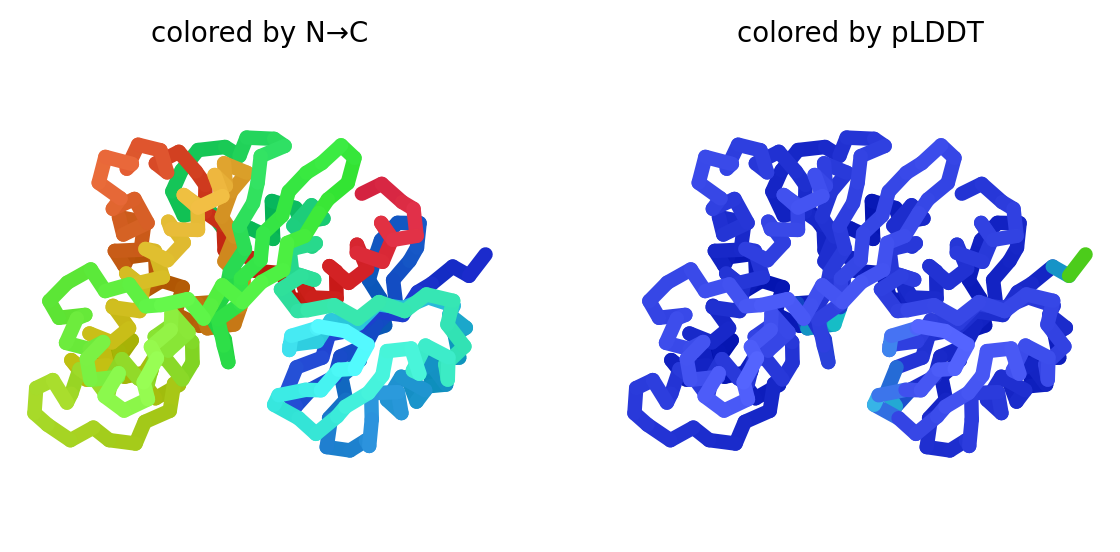

{'rank': [['rank_001_alphafold2_ptm_model_1_seed_000']],
 'metric': [[{'mean_plddt': 96.625,
    'ptm': 0.9169921875,
    'print_line': ' pLDDT=96.6 pTM=0.917'}]]}

In [11]:
import sys
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein

warnings.simplefilter(action="ignore", category=FutureWarning)

result_dir = "."
queries, is_complex = get_queries(queries_path) # Depend Whether it is complex or not
model_type = set_model_type(is_complex, model_type) # Specify model type (monomer : ptm, complex : multimer)
download_alphafold_params(model_type, Path("."))

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=dpi)
  plt.show()
  plt.close()

run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    model_order=[1],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi
)

# ⏭ Display 3D structure

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

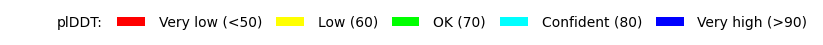

In [13]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend

rank_num = 1 # ["1", "2", "3", "4", "5"]
color = "lDDT" # ["chain", "lDDT", "rainbow"]

def show_ribbon_pdb(rank_num=1, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  view.zoomTo()
  return view

if use_amber:
  pdb_index = "*_relaxed_*.pdb"
else:
  pdb_index = "*_unrelaxed_*.pdb"

pdb_file = glob.glob(pdb_index)

show_ribbon_pdb(rank_num, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

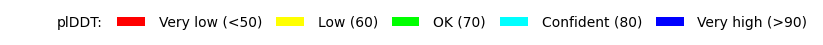

In [14]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend

rank_num = 1 # ["1", "2", "3", "4", "5"]
color = "lDDT" # ["white", "lDDT", "rainbow"]

def show_surface_pdb(rank_num=1, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.addSurface(py3Dmol.VDW,{"colorscheme": {'prop':'b','gradient': 'roygb','min':50,'max':90}})
  elif color == "rainbow":
    view.addSurface(py3Dmol.VDW,{"color": "spectrum"})
  elif color == "white":
    view.addSurface(py3Dmol.VDW,{"color": "white"})

  view.zoomTo()
  return view

if use_amber:
  pdb_index = "*_relaxed_*.pdb"
else:
  pdb_index = "*_unrelaxed_*.pdb"

pdb_file = glob.glob(pdb_index)

show_surface_pdb(pdb_file, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 